In [6]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [2]:
query_methods = {
    "random": partial(random_batch, n_instances=10),
    "uncertainty": partial(batch.uncertainty_batch_sampling, n_instances=10),
    **{
        name: partial(adversarial, Attack=attack, n_instances=10) for name, attack in 
        {
            "fgm": partial(FastGradientMethod, minimal=True),
        }.items()
        
    }
    
}

In [3]:
datasets = {
    "car": car
}

In [4]:
results = {name: dict() for name in datasets.keys()}

In [6]:
import libutil
reload(libutil); reload(libactive); reload(libadversarial)

<module 'libadversarial' from 'C:\\Users\\Zac\\Programming\\python\\research\\libadversarial.py'>

<ipython-input-17-67f06b04ee39>:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


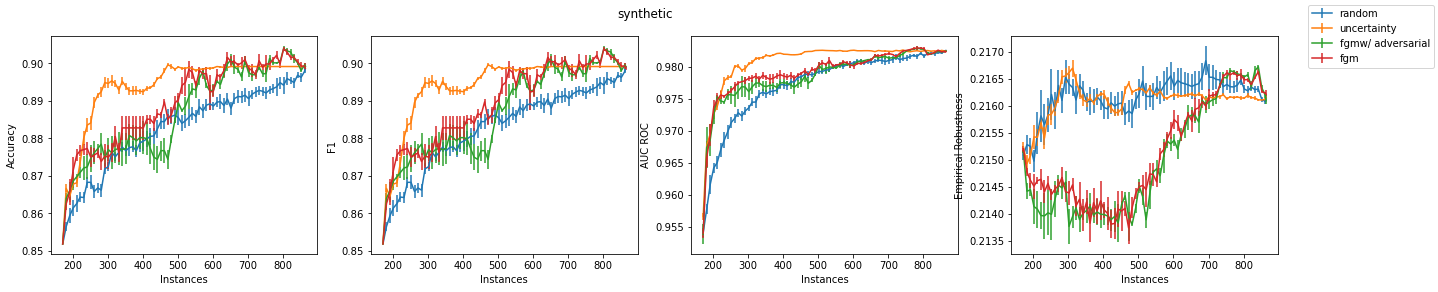

In [17]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(*dataset(), labeled_size=0.1)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for method_name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        if method_name == "fgm":
            for teach_advesarial in [True, False]:
                metrics = ProgressParallel(n_jobs=4, total=10 if method_name == "random" or method_name == "uncertainty" else 4, desc=f"Run", leave=False)(
                    delayed(
                        lambda X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method, teach_advesarial=teach_advesarial)
                    )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method))
                    for _ in range(10 if method_name == "random" or method_name == "uncertainty" else 4)
                )
                metrics, stderr = metrics[0].average(metrics[1:])
                results[dataset_name][f"{method_name}-{teach_advesarial}"] = (metrics, stderr)
                metrics.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_{teach_advesarial}.csv")
                stderr.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_{teach_advesarial}_stderr.csv")

                for i, ax in enumerate(axes.flatten()):
                    teach_advesarial_str = "w/ adversarial" if teach_advesarial else ""
                    ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{method_name}{teach_advesarial_str}" if i == 0 else "")
                    ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(dataset_name)
                    
        else:
            teach_advesarial = False
            metrics = ProgressParallel(n_jobs=4, total=10 if method_name == "random" or method_name == "uncertainty" else 4, desc=f"Run", leave=False)(
                delayed(
                    lambda X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn2(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method, teach_advesarial=teach_advesarial)
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method))
                for _ in range(10 if method_name == "random" or method_name == "uncertainty" else 4)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            results[dataset_name][method_name] = (metrics, stderr)
            metrics.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}.csv")
            stderr.to_csv(f"Experiments/experiment_robustness_{dataset_name}_method_{method_name}_stderr.csv")

            for i, ax in enumerate(axes.flatten()):
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{method_name}" if i == 0 else "")
                ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(dataset_name)
                
    fig.legend()

## Runner

In [17]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("car", lambda: lru_cache(car)())
        ("german", lambda: lru_cache()(german)())
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ('fgm', partial(adversarial, Attack=partial(FastGradientMethod, minimal=True), n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
        ("hopskipjump", partial(adversarial, Attack=partial(HopSkipJump, verbose=False), n_instances=10)),
        # this one has to be re-run, n_instances was wrong
        ("bim", partial(adversarial, Attack=BasicIterativeMethod, n_instances=10)),
        ("pgd", partial(adversarial, Attack=partial(ProjectedGradientDescentNumpy, verbose=False), n_instances=10)),
        ("newtonfool", partial(adversarial, Attack=partial(NewtonFool, verbose=False), n_instances=10)),
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 1
    }
}

In [23]:
results = librun.run(matrix)

In [32]:
reload(librun)

<module 'librun' from 'C:\\Users\\Zac\\Programming\\python\\research\\librun.py'>

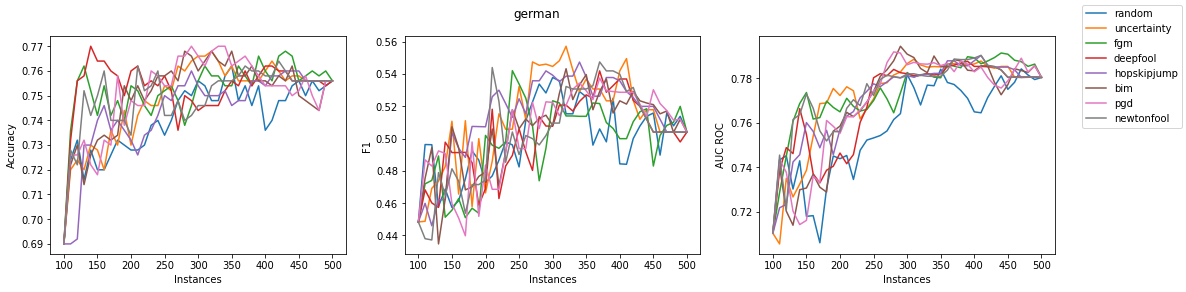

In [26]:
librun.plot(results)

In [42]:
reload(librun)
librun.table(results)

german
╒═════════════╤═══════════╤════════════╤═══════════════╤═══════════╕
│ method      │   AUC LAC │   AUC LF1C │   AUC AUC ROC │   max % @ │
╞═════════════╪═══════════╪════════════╪═══════════════╪═══════════╡
│ deepfool    │    301.59 │     200.9  │        307.83 │       130 │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ fgm         │    301.27 │     199.41 │        309.88 │       130 │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ pgd         │    300.47 │     201.86 │        307.87 │       180 │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ bim         │    300.19 │     202.45 │        307.61 │       240 │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ newtonfool  │    300.03 │     201.3  │        309.47 │       160 │
├─────────────┼───────────┼────────────┼───────────────┼───────────┤
│ uncertainty │    299.67 │     205.06 │        308.91 │       270 │
├─────────────┼───────────┼